**Simple data processing, no feature engineering, just encoding categoricals and imputing NAs.**

In [2]:
from FraudKagglePreProcessData import PreProcessData
import datetime
from datetime import timedelta
from datetime import datetime as dt
import pandas as pd
import numpy as np
import re
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import warnings
import os
from joblib import dump,load
from sklearn import metrics
import xgboost as xgb
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
warnings.filterwarnings("ignore")

<h2> Data Loading and prep <h2>

In [28]:
def load_and_merge_data(transaction_csv,identity_csv,isTrain):
    df_transaction = pd.read_csv(transaction_csv, index_col='TransactionID')
    df_identity = pd.read_csv(identity_csv, index_col='TransactionID')
    df = pd.merge(df_transaction, df_identity, on='TransactionID', how='left')
    del df_transaction
    del df_identity
    if isTrain:
        labels = df[['isFraud']]
        df.pop('isFraud')
    else:
        labels = []
    return df, labels


In [29]:
start=dt.now()
train,labels  = load_and_merge_data('./data/raw/train_transaction.csv','./data/raw/train_identity.csv',isTrain=True)
validate,vallabels  = load_and_merge_data('./data/raw/test_transaction.csv','./data/raw/test_identity.csv',isTrain=False)
finish=dt.now()
print('time taken: '+str(finish-start))

time taken: 0:00:57.601387


In [57]:
#train.to_pickle('./data/interim/train_joined.pkl')
#validate.to_pickle('./data/interim/test_joined.pkl')
#labels.to_pickle('./data/interim/labels.pkl')
train = pd.read_pickle('./data/interim/train_joined.pkl')
validate = pd.read_pickle('./data/interim/test_joined.pkl')
labels = pd.read_pickle('./data/interim/labels.pkl')

In [45]:
#train = train.head(2000)
#labels = labels.head(2000)

In [58]:
print(train.shape)
print(labels.shape)
print(validate.shape)

(590540, 432)
(590540, 1)
(506691, 432)


In [59]:
def process_dates(df):
    START_DATE = '2017-12-01'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['TransactionDT_converted'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
    #df['time_year'] = df['TransactionDT_converted'].dt.year
    #df['time_month'] = df['TransactionDT_converted'].dt.month
    df['time_dow'] = df['TransactionDT_converted'].dt.dayofweek
    df['time_hour'] = df['TransactionDT_converted'].dt.hour
    #df['time_day'] = df['TransactionDT_converted'].dt.day
    df = df.drop(columns="TransactionDT_converted")
    #df = df.drop(columns="time_year")
    #df = df.drop(columns="time_month")
    #df = df.drop(columns="time_day")
    return df
#start=dt.now()
train = process_dates(train)
validate = process_dates(validate)
#finish=dt.now()
#print('time taken: '+str(finish-start))

In [60]:
print(train.shape)
print(labels.shape)

(590540, 434)
(590540, 1)


In [61]:
def get_lists_of_numerical_categorical(df,regex):
    #Regex for categorical fields:
    categorical = []
    numerical = []

    #Create lists of categorical and numeircal fields:
    for i in df:
        if re.match(regex, i):
            categorical.append(i)
        else:
            numerical.append(i)
    return numerical,categorical
start=dt.now()
cat_columns_regex='ProductCD|card[1-6]|addr\d|\w_emaildomain|M[1-9]|time_|Device\w+|id_12|id_13|id_14|id_15|id_16|id_17|id_18|id_19|id_20|id_21|id_22|id_23|id_24|id_25|id_26|id_27|id_28|id_29|id_30|id_31|id_32|id_33|id_34|id_35|id_36|id_37|id_38'
numerical,categorical = get_lists_of_numerical_categorical(train,cat_columns_regex)
finish=dt.now()
print('time taken: '+str(finish-start))

time taken: 0:00:00.001994


In [62]:
def binary_encode_categoricals(df,categorical):
    encoder = ce.BinaryEncoder(cols=categorical).fit(df)
    return encoder
start = dt.now()
encoder= binary_encode_categoricals(train,categorical)
train = encoder.transform(train)
validate = encoder.transform(validate)
finish=dt.now()
print('time taken: '+str(finish-start))

time taken: 0:09:31.748077


In [64]:
print(train.shape)
print(labels.shape)

(590540, 675)
(590540, 1)


In [34]:
start=dt.now()
def numerically_encode_string_categoricals(df):
    for i in df.columns:
        if df[i].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df[i].values) + list(df[i].values))
            df[i] = lbl.transform(list(df[i].values))
    return df
#train = numerically_encode_string_categoricals(train)
#validate = numerically_encode_string_categoricals(validate)
finish=dt.now()
print('time taken: '+str(finish-start))

time taken: 0:00:00


In [65]:
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Impute missing values on numerical features with median and categorical with mode

In [66]:
start=dt.now()
def impute_cat_and_num(df,numerical,categorical):
    fill_NaN_numerical = SimpleImputer(missing_values=np.nan, strategy='median')
    #fill_NaN_categorical = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df[numerical] = fill_NaN_numerical.fit_transform(df[numerical])
    #df[categorical] = fill_NaN_categorical.fit_transform(df[categorical])
    return df
train = impute_cat_and_num(train,numerical,categorical)
validate = impute_cat_and_num(validate,numerical,categorical)
finish=dt.now()
print('time taken: '+str(finish-start))

time taken: 0:02:47.282540


In [67]:
print(train.shape)
print(labels.shape)

(590540, 675)
(590540, 1)


In [68]:
start=dt.now()
train = reduce_mem_usage(train)
finish=dt.now()
validate = reduce_mem_usage(validate)
print('time taken: '+str(finish-start))

Memory usage of dataframe is 3045.69 MB
Memory usage after optimization is: 652.17 MB
Decreased by 78.6%
Memory usage of dataframe is 2613.24 MB
Memory usage after optimization is: 567.30 MB
Decreased by 78.3%
time taken: 0:03:54.411998


In [69]:
print(train.shape)
print(labels.shape)

(590540, 675)
(590540, 1)


In [3]:
#train.to_pickle('./data/interim/train_joined.pkl')
#validate.to_pickle('./data/interim/test_joined.pkl')
#labels.to_pickle('./data/interim/labels.pkl')
train = pd.read_pickle('./data/interim/train_joined.pkl')
#validate = pd.read_pickle('./data/interim/test_joined.pkl')
labels = pd.read_pickle('./data/interim/labels.pkl')

In [129]:
#train=train.head(2000)
#validate=validate.head(2000)
#labels=labels.head(2000)

In [4]:
import gc
gc.collect()

20

Split train into train and test for validating initial model

In [5]:
start=dt.now()
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2,random_state=42)
finish=dt.now()
print('time taken: '+str(finish-start))
del train
del labels

time taken: 0:00:01.891091


<h3>XGBoost<h3>

In [131]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [125]:
import xgboost as xgb

1 1.857130527496338
2 0.9725604057312012
3 0.689157247543335
4 0.5794813632965088
5 0.587428092956543
6 0.5465373992919922
7 0.5046665668487549
8 0.50018310546875


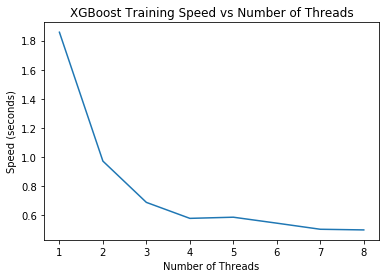

In [132]:
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import time
from matplotlib import pyplot
# load data
# data = train
dataset = train.values
# split data into X and y
X = X_train
y = y_train
# encode string class values as integers
label_encoded_y = y_train
# evaluate the effect of the number of threads
results = []
num_threads = [1, 2, 3, 4, 5 ,6,7,8]
for n in num_threads:
    start = time.time()
    model = XGBClassifier(nthread=n)
    model.fit(X, label_encoded_y)
    elapsed = time.time() - start
    print(n, elapsed)
    results.append(elapsed)
# plot results
pyplot.plot(num_threads, results)
pyplot.ylabel('Speed (seconds)')
pyplot.xlabel('Number of Threads')
pyplot.title('XGBoost Training Speed vs Number of Threads')
pyplot.show()

**with .fit and pandas DF**

**Grid search**

In [178]:
xgb_model = xgb.XGBClassifier()
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[7], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05,0.04,0.06], #so called `eta` value
              'max_depth': [10,11,12,13],
              'min_child_weight': [6,11,15],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5,100,1000], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]
             }
clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   #cv=StratifiedKFold(y_train, n_splits=5, shuffle=True), 
                   cv=2,
                   scoring='roc_auc',
                   verbose=2, refit=True)


clf.fit(X_train, y_train)

#trust your CV!
#best_parameters, score, _ = max(clf.cv_results_, key=lambda x: x[1])
#print('Raw AUC score:', score)
#for param_name in sorted(best_parameters.keys()):
#    print("%s: %r" % (param_name, best_parameters[param_name]))

results = pd.DataFrame(clf.cv_results_).sort_values('mean_test_score', ascending=False)

if 'all_results' in locals():
    all_results = pd.concat([all_results,results])
else:
    all_results = results
all_results[['params','mean_fit_time','mean_test_score']].sort_values('mean_test_score', ascending=False)

y_pred_prob=clf.predict_proba(X_test)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("ROC area under:",metrics.roc_auc_score(y_test, y_pred_prob[:,1]))

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   6 out of   6 | elapsed:    3.1s finished


Accuracy: 0.98
ROC area under: 0.8698979591836734


**Randomised grid search**

In [ ]:
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(100, 1000),
    "max_depth": st.randint(3, 15),
    "learning_rate": st.uniform(0.03, 0.06),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}
start=dt.now()
print(start)

xgbreg =xgb.XGBClassifier(nthreads=7)  

from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgbreg, params,  n_iter = 5, cv = 2, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc') 
#(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 2, verbose=2, random_state=42, n_jobs = -1)
gs.fit(X_train, y_train)  
finish=dt.now()
print('time taken: '+str(finish-start))
xgbm = gs.best_estimator_
results = pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False)
results.filter(regex='mean_test_score|mean_fit_time|param')

2019-09-24 09:07:14.602377
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [7]:
results.filter(regex='mean_test_score|mean_fit_time|param')

NameError: name 'results' is not defined

In [ ]:
results = pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False)
results.to_pickle('./data/interim/grid_search_results.pkl')

In [20]:
xgbm = gs.best_estimator_
y_pred_prob=xgbm.predict_proba(X_test)
y_pred=xgbm.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("ROC area under:",metrics.roc_auc_score(y_test, y_pred_prob[:,1]))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Balanced Accuracy:",metrics.balanced_accuracy_score(y_test, y_pred))
print("Precision Score:",metrics.precision_score(y_test, y_pred,pos_label=1,average='binary'))

Accuracy: 0.9788922003589935
ROC area under: 0.9374086129164142
Recall: 0.4552098066949552
Balanced Accuracy: 0.7268057183405396
Precision Score: 0.9138665404637956


In [23]:
validate = pd.read_pickle('./data/interim/test_joined.pkl')
val_pred=xgbm.predict_proba(validate)

In [25]:
datetimestring=dt.now().strftime("%d-%m-%Y_%H-%M-%S")
os.mkdir('./data/predictions/'+datetimestring)
validate['isFraud'] = val_pred[:,1]
validate['TransactionID']=list(validate.index)
validate[['TransactionID','isFraud']].to_csv('./data/predictions/'+datetimestring+'/prediction_results_'+datetimestring+'.csv',index = False)
dump(xgbm, './data/predictions/'+datetimestring+'/XGBoost_'+datetimestring+'.joblib')
dump(gs, './data/predictions/'+datetimestring+'/XGBoost_grid_search'+datetimestring+'.joblib')

['./data/predictions/24-09-2019_08-59-24/XGBoost_grid_search24-09-2019_08-59-24.joblib']

**Normal training with SciKit wrapper**

In [116]:
import xgboost as xgb
start=dt.now()


xgbm = xgb.XGBClassifier(
        nthread=7,
        #n_estimators=1000,
        #max_depth=10,
        max_depth=11,
        #learning_rate=0.05,
        learning_rate=0.053,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='auto',
        booster='gbtree',
        random_state = 42
    )

xgbm.fit(X_train, y_train)
finish=dt.now()
print('time taken: '+str(finish-start))

time taken: 0:10:17.327453


In [86]:
#import pickle
#xgbm_old = load('./data/interim/xgb_job_dir_15_model.pkl')

In [19]:
xgbm.score(X_test, y_test)

0.9788922003589935

In [89]:
import xgboost as xgb
y_pred_prob=xgbm.predict_proba(X_test)
y_pred=xgbm.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("ROC area under:",metrics.roc_auc_score(y_test, y_pred_prob[:,1]))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Balanced Accuracy:",metrics.balanced_accuracy_score(y_test, y_pred))
print("Precision Score:",metrics.precision_score(y_test, y_pred,pos_label=1,average='binary'))

Accuracy: 0.980610966234294
ROC area under: 0.9460547252938232
Recall: 0.5025931164545026
Balanced Accuracy: 0.7505061554731368
Precision Score: 0.9221453287197232


In [5]:
import xgboost as xgb
y_pred_prob=xgbm.predict_proba(X_test)
y_pred=xgbm.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("ROC area under:",metrics.roc_auc_score(y_test, y_pred_prob[:,1]))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Balanced Accuracy:",metrics.balanced_accuracy_score(y_test, y_pred))
print("Precision Score:",metrics.precision_score(y_test, y_pred,pos_label=1,average='binary'))

Accuracy: 0.9859450672266061
ROC area under: 0.9740302624838564
Recall: 0.6322489391796322
Balanced Accuracy: 0.8156853569486414
Precision Score: 0.9640546369518332


In [18]:
tp=0
fp=0
fn=0
y_real = y_test['isFraud']
for i,y_real_value in enumerate(y_real):
    if y_real_value == y_pred[i] and y_pred[i]==1:
        tp=tp+1
    if y_real_value != y_pred[i] and y_pred[i]==1:
        fp=fp+1
    if y_real_value != y_pred[i] and y_pred[i]==0:
        fn=fn+1
tp/(fn+tp)

0.4552098066949552

**With .train and DMatrix**

In [128]:
import xgboost as xgb
start=dt.now()
#param_dict={'nthread' : 7,
#        'n_estimators':500,
#        'max_depth':9,
#        'learning_rate':0.05,
#        'subsample':0.9,
#        'colsample_bytree':0.9,
#        'tree_method':'auto'}
param_dict = {'base_score':0.5,
'booster':'gbtree',
'colsample_bylevel':1,
'colsample_bynode':1,
'colsample_bytree':0.9,
'gamma':0,
'learning_rate':0.05,
'max_delta_step':0,
'max_depth':9,
'min_child_weight':1,
'n_estimators':500,#this has to be entered explicitly in the function
'n_jobs':1,
'nthread':7,
'objective':'binary:logistic',
'random_state':42,
'reg_alpha':0,
'reg_lambda':1,
'scale_pos_weight':1,
'seed':42,
'subsample':0.9,
'tree_method':'auto',
'verbosity':1}
#param_dict = {}
xgbm_dmatrix = xgb.train(param_dict, dtrain, param_dict['n_estimators'])
finish=dt.now()
print('time taken: '+str(finish-start))

time taken: 0:03:27.776969


In [112]:
y_pred_dtest_prob=xgbm_dmatrix.predict(dtest)
roc_auc_score(y_test, y_pred_dtest_prob)

0.9337600767072696

In [122]:
#validate=validate.drop(['isFraud','TransactionID'], axis=1)
import xgboost as xgb
val_pred=xgbm.predict_proba(validate)

In [123]:
datetimestring=dt.now().strftime("%d-%m-%Y_%H-%M-%S")
os.mkdir('./data/predictions/'+datetimestring)
validate['isFraud'] = val_pred[:,1]
validate['TransactionID']=list(validate.index)
validate[['TransactionID','isFraud']].to_csv('./data/predictions/'+datetimestring+'/prediction_results_'+datetimestring+'.csv',index = False)
dump(xgbm, './data/predictions/'+datetimestring+'/XGBoost_'+datetimestring+'.joblib')

['./data/predictions/22-09-2019_09-14-41/XGBoost_22-09-2019_09-14-41.joblib']

<h3> Random Forest <h3>

In [122]:
start=dt.now()
rf = RandomForestClassifier(random_state=42,n_estimators = 100, max_depth=25)
rf.fit(X_train, y_train)
finish=dt.now()
print('time taken: '+str(finish-start))
important_features = pd.DataFrame(rf.feature_importances_,features).sort_values(0,ascending=False)
important_features.head(5)

time taken: 0:00:09.323619


,0
card1,0.019595
TransactionAmt,0.017763
TransactionDT,0.014294
C13,0.014257
addr1,0.013064


In [123]:
y_pred_prob=rf.predict_proba(X_test)
y_pred=rf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("ROC area under:",metrics.roc_auc_score(y_test, y_pred_prob[:,1]))

Accuracy: 0.9824
ROC area under: 0.8784834989151536


In [170]:
all_results = pd.read_pickle('./data/interim/grid_search_results.pkl')

**Grid search using cross validation for hyperparameter tuning**

In [171]:
rf = RandomForestClassifier(random_state = 42)
param = {'n_estimators': [300, 500],
        'max_depth': [50]}

gs = GridSearchCV(rf, param, cv=3, n_jobs=-1,scoring='roc_auc',verbose=2)
gs_fit = gs.fit(X_train, y_train)

results = pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)

if 'all_results' in locals():
    all_results = pd.concat([all_results,results])
else:
    all_results = results

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.3s finished


In [172]:
all_results[['params','mean_fit_time','mean_test_score']].sort_values('mean_test_score', ascending=False)

,params,mean_fit_time,mean_test_score
0,"{'max_depth': 50, 'n_estimators': 300}",0.462763,0.973303
0,"{'max_depth': 50, 'n_estimators': 300}",0.234372,0.973303
0,"{'max_depth': 50, 'n_estimators': 300}",0.222405,0.973303
0,"{'max_depth': 50, 'n_estimators': 300}",0.233708,0.973303
1,"{'max_depth': 50, 'n_estimators': 500}",0.728053,0.971394
1,"{'max_depth': 50, 'n_estimators': 500}",0.366038,0.971394
1,"{'max_depth': 50, 'n_estimators': 500}",0.349732,0.971394
1,"{'max_depth': 50, 'n_estimators': 500}",0.369346,0.971394


In [173]:
all_results.to_pickle('./data/interim/grid_search_results.pkl')

**Train new model with best hyper parameters from above**

In [174]:
%time
rf = RandomForestClassifier(random_state=42,n_estimators = 500, max_depth=25)
rf.fit(train, labels)
finish=datetime.now()

Wall time: 0 ns


**get predictions on un-labelled data:**

In [175]:
val_pred=rf.predict_proba(validate)

In [176]:
datetimestring=dt.now().strftime("%d-%m-%Y_%H-%M-%S")
os.mkdir('./data/predictions/'+datetimestring)
validate['isFraud'] = val_pred[:,1]
validate['TransactionID']=list(validate.index)
validate[['TransactionID','isFraud']].to_csv('./data/predictions/'+datetimestring+'/prediction_results.csv',index = False)
dump(rf, './data/predictions/'+datetimestring+'/random_foest_base.joblib')

['./data/predictions/13-09-2019_12-15-36/random_foest_base.joblib']

In [100]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

                       X_train: 521.7MiB
                        X_test: 130.4MiB
                       y_train:   7.2MiB
                        y_test:   1.8MiB
                        y_pred: 922.8KiB
                     numerical:   3.2KiB
                           _i7:   1.9KiB
                          _i35:   1.9KiB
                          _i65:   1.9KiB
        RandomForestClassifier:   1.4KiB
